# Robot Simulation
This simulation is used for data generation for prognostic algorithm testing. The equations of motion are generated automatically using Kane's method via PyDy.

A lot of the content here comes from [this](https://github.com/pydy/pydy-tutorial-human-standing) tutorial by Jason Moore but I'll leave out the learning and use different variable names.

In [20]:
from __future__ import print_function, division
from sympy import symbols, simplify, pi
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame, Point
from sympy.physics.vector import init_vprinting
from pydy.system import System
import numpy as np
init_vprinting(use_latex='mathjax', pretty_print=False)


# Reference Frames

In [21]:
inertial_frame = ReferenceFrame('I')
upper_arm_frame = ReferenceFrame('U')
fore_arm_frame = ReferenceFrame('F')
# theta1 - shoulder, theta2 - elbow
theta1, theta2 = dynamicsymbols('theta1, theta2')


In [22]:
upper_arm_frame.orient(inertial_frame, 'Axis', (theta1, inertial_frame.z))
fore_arm_frame.orient(upper_arm_frame, 'Axis', (theta2, upper_arm_frame.z))

# Points

In [23]:
# Joints
shoulder = Point('S')
upper_arm_length = symbols('l_U')

elbow = Point('E')
elbow.set_pos(shoulder, upper_arm_length * upper_arm_frame.y)

end_effector = Point('EE')
fore_arm_length = symbols('l_F')
end_effector.set_pos(elbow, fore_arm_length * fore_arm_frame.y)
end_effector.pos_from(shoulder)


l_U*U.y + l_F*F.y

In [24]:
# Center of Masses
upper_arm_com_length, fore_arm_com_length = symbols('d_U, d_F')

upper_arm_mass_center = Point('U_o')
upper_arm_mass_center.set_pos(shoulder, upper_arm_com_length * upper_arm_frame.y)

fore_arm_mass_center = Point('F_o')
fore_arm_mass_center.set_pos(elbow, fore_arm_com_length * fore_arm_frame.y)
fore_arm_mass_center.pos_from(shoulder)


l_U*U.y + d_F*F.y

# Kinematical Differential Equations

In [25]:
# the generalized speeds are the angular velocities of the joints
omega1, omega2 = dynamicsymbols('omega1, omega2')

kinematical_differential_equations = [omega1 - theta1.diff(),
                                      omega2 - theta2.diff()]
kinematical_differential_equations


[omega1 - theta1', omega2 - theta2']

# Velocities

In [26]:
upper_arm_frame.set_ang_vel(inertial_frame, omega1 * inertial_frame.z)
fore_arm_frame.set_ang_vel(upper_arm_frame, omega2 * upper_arm_frame.z)
fore_arm_frame.ang_vel_in(inertial_frame)


omega1*I.z + omega2*U.z

In [27]:
shoulder.set_vel(inertial_frame, 0)
upper_arm_mass_center.v2pt_theory(shoulder, inertial_frame, upper_arm_frame)

elbow.v2pt_theory(shoulder, inertial_frame, upper_arm_frame)

fore_arm_mass_center.v2pt_theory(elbow, inertial_frame, fore_arm_frame)

end_effector.v2pt_theory(elbow, inertial_frame, fore_arm_frame)


- l_U*omega1*U.x - l_F*(omega1 + omega2)*F.x

# Inertia

In [28]:
from sympy.physics.mechanics import inertia, RigidBody

# Mass
upper_arm_mass, fore_arm_mass = symbols('m_U, m_F')

# Inertia
upper_arm_inertia, fore_arm_inertia = symbols('I_Uz, I_Fz')

upper_arm_inertia_dyadic = inertia(upper_arm_frame, 0, 0, upper_arm_inertia)

upper_arm_central_inertia = (upper_arm_inertia_dyadic, upper_arm_mass_center)

fore_arm_inertia_dyadic = inertia(fore_arm_frame, 0, 0, fore_arm_inertia)

fore_arm_central_inertia = (fore_arm_inertia_dyadic, fore_arm_mass_center)

# rigid bodies
upper_arm = RigidBody('Upper Arm', upper_arm_mass_center, upper_arm_frame,
                      upper_arm_mass, upper_arm_central_inertia)

fore_arm = RigidBody('Upper Leg', fore_arm_mass_center, fore_arm_frame,
                     fore_arm_mass, fore_arm_central_inertia)


# Kinetics

In [29]:
# gravity
g = symbols('g')
upper_arm_grav = (upper_arm_mass_center,-upper_arm_mass * g * inertial_frame.y)

fore_arm_grav = (fore_arm_mass_center,-fore_arm_mass * g * inertial_frame.y)

# square wave


In [30]:
# joint torques

shoulder_torque, elbow_torque = dynamicsymbols('T_s, T_e')

upper_arm_torque = (upper_arm_frame,
                    shoulder_torque * inertial_frame.z - elbow_torque *
                    inertial_frame.z)

fore_arm_torque = (fore_arm_frame,
                    elbow_torque * inertial_frame.z)


# Equations of Motion

In [31]:
from sympy.physics.mechanics import KanesMethod

coordinates = [theta1, theta2]

speeds = [omega1, omega2]

kane = KanesMethod(inertial_frame,
                   coordinates,
                   speeds,
                   kinematical_differential_equations)

loads = [
    upper_arm_grav,
    fore_arm_grav,
    upper_arm_torque,
    fore_arm_torque]

bodies = [upper_arm, fore_arm]

fr, frstar = kane.kanes_equations(bodies, loads)

mass_matrix = kane.mass_matrix_full
forcing_vector = kane.forcing_full


sys = System(kane)

upper_arm_radius_constant = 0.054
upper_arm_mass_constant = 8.393
fore_arm_length_constant = 0.392  # todo quick hack
fore_arm_radius_constant = 0.060
fore_arm_mass_constant = 2.275

# https://github.com/ros-industrial/universal_robot/blob/kinetic-devel/ur_e_description/urdf/ur5e.urdf.xacro
sys.constants = {
    upper_arm_length: 0.425,  # [m]
    upper_arm_com_length: 0.2125,  # [m]
    upper_arm_mass: 8.393,  # [kg]
    # [kg*m^2]
    upper_arm_inertia: 0.5 * upper_arm_mass_constant * upper_arm_radius_constant ** 2,
    # fore_arm_length: 0.392,  # [m]
    fore_arm_com_length: 0.11993,  # [m]
    fore_arm_mass: fore_arm_mass_constant,  # [kg]
    # [kg*m^2]
    fore_arm_inertia: 0.5 * fore_arm_mass_constant * fore_arm_radius_constant ** 2,
    g: 9.806
}


In [32]:
sys.constants

{I_Fz: 0.004095, I_Uz: 0.012236994, d_F: 0.11993, d_U: 0.2125, g: 9.806, l_U: 0.425, m_F: 2.275, m_U: 8.393}

# Simulation

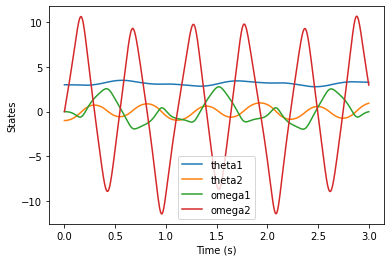

In [33]:
sys.times = np.linspace(0.0, 3.0, num=1000)
sys.initial_conditions = {
                          theta1: 3.0,
                          theta2: -1.0,
                          omega1: 0.0,
                          omega2: 0.0,
                         }
states = sys.integrate()


import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(sys.times, states)
ax.set_ylabel('States')
ax.set_xlabel('Time (s)')
ax.legend(['theta1', 'theta2', 'omega1', 'omega2'])
plt.show()

In [34]:
from pydy.viz import Sphere, Cylinder, VisualizationFrame, Scene

shoulder_shape = Cylinder(
    name='shoulder', color='grey', radius=0.06, length=0.13)
elbow_shape = Cylinder(name='elbow', color='grey', radius=0.06, length=0.13)

shoulder_viz_frame = VisualizationFrame(
    'shoulder', inertial_frame.orientnew('side', 'Axis', (pi/2, inertial_frame.x)), shoulder, shoulder_shape)
elbow_viz_frame = VisualizationFrame(
    'elbow', inertial_frame.orientnew('side', 'Axis', (pi/2, inertial_frame.x)), elbow, elbow_shape)

upper_arm_center = Point('l_c')
fore_arm_center = Point('u_c')


upper_arm_center.set_pos(
    shoulder, sys.constants[upper_arm_length]/2 * upper_arm_frame.y)
fore_arm_center.set_pos(elbow, fore_arm_length_constant/2 * fore_arm_frame.y)

upper_arm_shape = Cylinder(name='upper arm',
                           radius=upper_arm_radius_constant,
                           length=sys.constants[upper_arm_length],
                           color='lightskyblue')

fore_arm_shape = Cylinder(name='fore arm',
                          radius=fore_arm_radius_constant,
                          length=fore_arm_length_constant,
                          color='lightskyblue')

upper_arm_viz_frame = VisualizationFrame('Upper Arm', upper_arm_frame,
                                         upper_arm_center, upper_arm_shape)

fore_arm_viz_frame = VisualizationFrame('Fore Arm', fore_arm_frame,
                                        fore_arm_center, fore_arm_shape)

scene = Scene(inertial_frame, shoulder, system=sys)

scene.visualization_frames = [shoulder_viz_frame, elbow_viz_frame,
                              upper_arm_viz_frame, fore_arm_viz_frame]

scene.display_jupyter()


In [35]:
# https://github.com/pydy/pydy-tutorial-human-standing/blob/master/notebooks/solution/control.py


# Controller Design

from numpy import zeros, matrix, eye, dot, asarray
from numpy.linalg import inv
from scipy.integrate import odeint
from scipy.linalg import solve_continuous_are

equilibrium_point = zeros(len(coordinates + speeds))
equilibrium_dict = dict(zip(coordinates + speeds, equilibrium_point))

linear_state_matrix, linear_input_matrix, inputs = \
    kane.linearize(new_method=True, A_and_B=True)
f_A_lin = linear_state_matrix.subs(sys.constants).subs(equilibrium_dict)
f_B_lin = linear_input_matrix.subs(sys.constants).subs(equilibrium_dict)
m_mat = mass_matrix.subs(sys.constants).subs(equilibrium_dict)

A = matrix(m_mat.inv() * f_A_lin).astype(float)
B = matrix(m_mat.inv() * f_B_lin).astype(float)

Q = matrix(eye(4))

R = matrix(eye(2))

S = solve_continuous_are(A, B, Q, R)

K = inv(R) * B.T * S

# This is an annoying little issue. We specified the order of things when
# creating the rhs function, but the linearize function returns the F_B
# matrix in the order corresponding to whatever order it finds the joint
# torques. This would also screw things up if we specified a different
# ordering of the coordinates and speeds as the standard kane._q + kane._u

K = K[[1,0], :] # this is dumb haha


def controller(x, t):
    return -asarray(dot(K, x)).flatten() #u

y = odeint(sys.generate_ode_function(), [2,3,0,0], sys.times, args=(controller,sys.constants))


Text(0, 0.5, 'angle (rad,rad/s)')

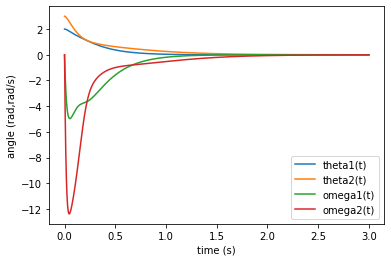

In [36]:
plt.plot(sys.times,y)
plt.legend(sys.states)
plt.xlabel('time (s)')
plt.ylabel('angle (rad,rad/s)')

In [37]:
scene = Scene(inertial_frame, shoulder)

scene.visualization_frames = [shoulder_viz_frame, elbow_viz_frame,
                              upper_arm_viz_frame, fore_arm_viz_frame]

scene.states_symbols = coordinates + speeds
scene.constants = sys.constants
scene.states_trajectories = y
scene.times = sys.times
scene.display_jupyter()